In [38]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
from typing import NamedTuple, Dict
from sklearn import linear_model

In [56]:
def calc_Y(A: np.ndarray, U: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    """
    Y = cos(alpha + beta*A + U)
    """
    return np.cos(alpha + beta*A + U)

def calc_A(Z: np.ndarray, U: np.ndarray, e: np.ndarray, gamma: float, pi: np.ndarray, delta: float) -> np.ndarray:
    """
    A = gamma + pi*Z + delta*U + e
    """
    return gamma + np.dot(pi, Z.T) + delta*U + e
        

def generatate_data(n_sample: int, params: np.ndarray,  seed=1001, Zdim: int = 1, Z_noise: float = np.sqrt(3), U_noise: float = 1, e_Noise: float = 1):
    rng = default_rng(seed=seed)
    alpha, beta, gamma, pi, delta = params
    
    # U = rng.uniform(-1, 2, n_sample)
    U = rng.normal(0, U_noise, n_sample)
    e = rng.normal(0, e_Noise, n_sample)
    Z = rng.normal(0, Z_noise, [n_sample, Zdim])
    A = calc_A(Z, U, e, gamma, pi, delta) 
    Y = calc_Y(A, U, alpha, beta)
    return U, e, Z, A, Y

def cal_true_effect(a: float, params, U_noise: float = 1, n_MC: int = 10000):
    """
    To estimate true effect
    n_MC affects MC error, seed is fixed!
    """
    rng = default_rng(seed=42)
    alpha, beta, gamma, pi, delta = params
    
    # U = rng.uniform(-1, 2, n_MC)
    U = rng.normal(0, U_noise, n_MC)
    Y = calc_Y(a, U, alpha, beta)
    return np.mean(Y)


def generate_struc_data(params, a_start: float, a_end: float, n_steps: int = 100, U_noise: float = 1, n_MC: int = 10000):
    """
    from a_start to a_end, calc Y effect
    """
    a_steps = np.linspace(a_start, a_end, n_steps)
    y_struc = np.array([cal_true_effect(a, params, U_noise, n_MC) for a in a_steps])
    return a_steps, y_struc

C:\Users\Benedikt\AppData\Local\Temp\ipykernel_19720\174122972.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  params_true = np.array([alpha_true, beta_true, gamma_true, pi_true, delta_true])


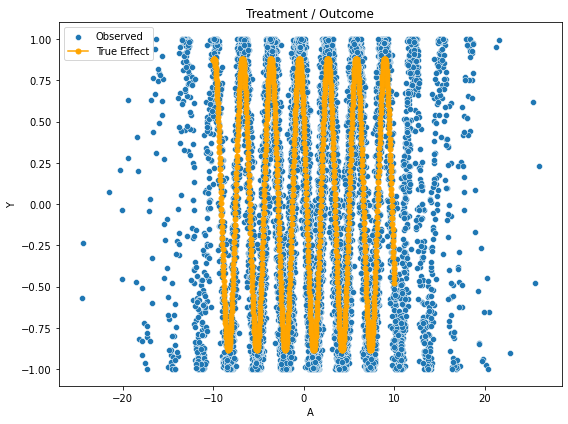

In [57]:
# Sample Parameters
random_seed = 1001
n_sample = 10000
n_MC = 10000
# Number of Instruments
Zdim = 2
# True Parameters
alpha_true = 1
beta_true = 2
gamma_true = 1
pi_true = np.array([3, 2])
delta_true = 1 
params_true = np.array([alpha_true, beta_true, gamma_true, pi_true, delta_true])
# Noise Parameters
U_noise = 0.5
e_Noise = 0.5
Z_noise = np.sqrt(3)

U_data, e_data, Z_data, A_data, Y_data = generatate_data(n_sample, params_true,  seed=random_seed, Zdim = Zdim, 
                                                         Z_noise = Z_noise, U_noise = U_noise, e_Noise = e_Noise)

# generate structural Data (True Effect)
a_steps, y_struc = generate_struc_data(params_true, a_start=-10, a_end=10, n_steps = 1000, U_noise = U_noise, n_MC = n_MC)

# Plot Results
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(x=A_data, y=Y_data, label='Observed', ax=ax1)
ax1.plot(a_steps, y_struc, color='orange', marker='o', label="True Effect", markersize=5)
ax1.set_title('Treatment / Outcome')
ax1.set_xlabel('A')
ax1.set_ylabel('Y')
ax1.legend()


# fig.suptitle('Visualization')
plt.tight_layout()
plt.show()

### GMM

In [58]:
def g_vec(y, var_model, var_inst, params_gmm):
    """
    g vector for GMM
    y: outcome
    var_model: A
    var_inst: Z
    """
    # calc error (problem specific)
    alpha, beta = params_gmm
    a = var_model
    error = np.arccos(y) - alpha  - beta*a
    # create moment condions
    n_moment_cond = var_inst.shape[1]
    moment_cond = []
    for i in range(n_moment_cond):
        m = np.mean(var_inst[:, i] * error)
        moment_cond = np.append(moment_cond, m)
    g =  np.column_stack(moment_cond).T
    return g

def criterion(params, *var): 
    """
    c(params) = g.T(params) W_hat g(params)
    Aim: min c in params
    """
    y, var_model, var_inst, W_hat = var
    g = g_vec(y, var_model, var_inst, params)
    crit_val = np.dot(np.dot(g.T, W_hat), g) 
    return crit_val

In [67]:
# Initial Parameters
alpha_init = 0
beta_init = 0
params_init = np.array([alpha_init, beta_init])
W_hat = np.eye(2)

var_model = np.c_[A_data]
var_inst = np.c_[Z_data]
gmm_args = (Y_data, var_model, var_inst, W_hat)
print("Initial Result:", criterion(params_init, *gmm_args))

results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-6, options  = {"maxiter":100000, "disp":True})
results

Initial Result: [[0.01033838]]
Optimization terminated successfully.
         Current function value: 0.001456
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5


      fun: 0.001455797066678024
 hess_inv: array([[26.7200338 , 30.58037729],
       [30.58037729, 37.35918532]])
      jac: array([-3.64816515e-08, -4.26953193e-08])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 2
     njev: 5
   status: 0
  success: True
        x: array([0.68138091, 0.81014222])

In [68]:
def model(A: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    """
    Y = cos(alpha + beta*A)
    """
    return np.cos(alpha + beta*A)


def cal_pred_effect(a: float, params_pred):
    """
    To estimate pred effect
    """
    
    alpha, beta = params_pred
    Y = model(a, alpha, beta)
    return Y

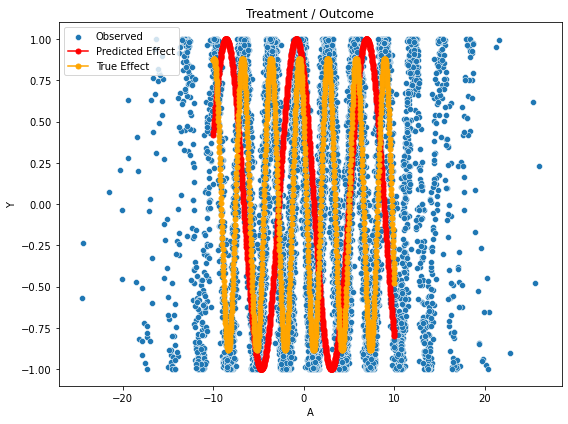

In [69]:
params_pred = results.x
# params_pred = [alpha_true, beta_true]
y_pred = [cal_pred_effect(a, params_pred) for a in a_steps]

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(x=A_data, y=Y_data, label='Observed', ax=ax1)
ax1.plot(a_steps, y_pred, color='red', marker='o', label="Predicted Effect", markersize=5)
ax1.plot(a_steps, y_struc, color='orange', marker='o', label="True Effect", markersize=5)


ax1.set_title('Treatment / Outcome')
ax1.set_xlabel('A')
ax1.set_ylabel('Y')
ax1.legend()


# fig.suptitle('Visualization')
plt.tight_layout()
plt.show()

In [65]:
### Arccos Is not the true Inverse, since limited on [0, Pi]

In [66]:
y = Y_data
np.sum(np.arccos(np.cos(y)) == y), np.sum(np.cos(np.arccos(y)) == y)

(2593, 6533)